In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os

In [2]:
class wifimodel():
    def __init__(self, location):
        self.train_dir = f'../../data/{location}/train_0F/'
        self.test_dir = f'../../data/{location}/test_0F/'
        
        self.location = location
        self.model_df = pd.DataFrame()
        self.test_df = pd.DataFrame()

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0

        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])

        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../../mag/{location}/0Fmagx.txt', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]
        plt.imshow(self.mag_df, cmap='jet', interpolation='none')

    def cal_area(self, posx, posy):
        cnt = 0
        temp = self.ref_mag_df.iloc[int(min(posx)): int(max(posx)), int(min(posy)): int(max(posy))]
        return sum(temp[temp != 0.0].count())
    
    def cal_area2(self, posx, posy):
        cnt = 0
        for i in range(len(posx)):
            if self.mag_df.iloc[posx[i], posy[i]] != 0.0:
                cnt += 1
        return cnt
    
    def define_range(self, range_num, rssi_range_num):
        self.range_num = range_num
        self.rssi_range_num = rssi_range_num
    
    #RSSI 도 이용하기 대문에 ref_wifi와 rssiwifi를 정의해준다.
    def create_refwifi(self, rssi_thres):
        self.rssi_thres = rssi_thres
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        self.rssiwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        self.rssi_max = np.max(fil_model_df['RSSI'])
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = 1
                #refwifi는 해당 ssid가 존재하면 1로 지정을 해줬는데 rssiwifi는 해당 ssid의 측정된 rssi 값으로 지정해준다.
                self.rssiwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = rssi

    def test_all(self):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        fail_list = []
        

        for x in self.test_x_list:
            for y in self.test_y_list:
                compare_list = np.array([0 for i in range(len(self.SSID_list))])
                compare_list_rssi = np.array([0 for i in range(len(self.SSID_list))])

                compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
                if compare_df.empty == False:
                    for i in range(compare_df.shape[0]):
                        if (compare_df.iloc[i, 4] in self.SSID_list):
                            compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1
                            #test data의 rssi 값으로 compare_list_rssi 값을 채워준다.
                            compare_list_rssi[self.SSID_list.index(compare_df.iloc[i, 4])] = compare_df.iloc[i, 5]

                    temp_wifi = self.refwifi - compare_list
                    temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
                    
                    #기준 self.rssiwifi와 비교하기 위해 연산을 해주는데
                    #절대값을 해줘서 두 rssi값의 차이를 양수화해준다.
                    temp_rssi_wifi = abs(self.rssiwifi - compare_list_rssi)
                    #한쪽에는 ssid가 확인이 되는데 한쪽에는 확인이 안되게 되면
                    #RSSI 차이 연산시 0 과 측정된 rssi 측정치 (ex. -78) 의 차이를 유사도 비교에 사용하는 것은 무의미하기 때문에
                    #0 과 0이 아닌 값의 차이가 계산된 부분들을 다 0으로 바꿔준다.
                    temp_rssi_wifi = np.where(abs(temp_rssi_wifi) >= abs(self.rssi_max), 0, temp_rssi_wifi)

                    sum_temp = temp_wifi.sum(axis=2)
                    
                    #이제 RSSI 값을 이용하여 유사도 계산을 하게 될텐데
                    #RSSI 값을 비교할때 각 좌표에서의 RSSI 차이 값의 평균을 해주게 된다.
                    #그렇기 때문에 temp_wifi(self.refwifi - compare_list)를 해서 둘다 존재하는 ssid 개수가 0인 좌표에 대해서
                    #평균을 해줄때 분모에 0이 들어가면 안되기 때문에 해당 좌표에 대해서 0인 값을 0에 가까운 값으로 변환해준다.
                    sum_temp_for_rssi = copy.deepcopy(sum_temp)
                    sum_temp_for_rssi = np.where(sum_temp_for_rssi == 0, 0.00001, sum_temp)
                    #temp_rssi_wifi(rssi 차이)를 각 좌표마다 다 더해준다.
                    sum_rssi_temp = temp_rssi_wifi.sum(axis=2)
                    
                    #각 좌표마다 rssi 차이 평균을 계산한다.
                    sum_rssi_temp = sum_rssi_temp / sum_temp_for_rssi
                    
                    #SSID 둘다 존재하는 개수 (sum_temp)의 unique list 확인
                    sum_np = np.unique(sum_temp.flatten())[:: -1]
                    
                    if len(sum_np) <= self.range_num:
                        range_idx = len(sum_np) - 1
                    else:
                        range_idx = self.range_num

                    if range_idx == -1:
                        rangeval = 0
                    else:
                        #self.range_num에 따라 Bit vector 유사도 척도 값 확인
                        rangeval = np.unique(sum_np)[:: - 1][range_idx]
                    
                    #sum_rssi_temp 좌표 중에서 rangeval(Bit vector 유사도 척도) 이상의 좌표들만 이용해서
                    #rssi 값 차이의 평균의 unique list 계산
                    sum_rssi_np = np.unique(sum_rssi_temp[np.where(sum_temp >= rangeval)].flatten())
                    
                    #RSSI vector 유사도 척도 값 계산(Bit vector와 유사)
                    if len(sum_rssi_np) <= self.rssi_range_num:
                        range_idx = len(sum_rssi_np) - 1
                    else:
                        range_idx = self.rssi_range_num

                    if range_idx == -1:
                        rssi_rangeval = 0
                    else:
                        rssi_rangeval = np.unique(sum_rssi_np)[range_idx]
                    
                    #RSSI vector 유사도 척도값 이하(RSSI 값 차이가 작을 수록 유사하기 때문에), Bit vector 유사도 척도 값 이상인
                    #좌표들 확인
                    coords = np.where((sum_temp >= rangeval) & (sum_rssi_temp <= rssi_rangeval))

                    if (min(coords[0]) - 12 <= x <= max(coords[0]) + 12) and (min(coords[1]) - 12 <= y <= max(coords[1]) + 12):
                        cnt += 1
                        coords_list.append([x, y, coords])
                        self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                                              / (self.maxX * self.maxY))
                    else:
                        fail_list.append([x, y, coords])
                    tot_cnt += 1
                    
                    if (tot_cnt % 100 == 0):
                        print(f"현재 진행 상황 : {tot_cnt} 회")
                        print(f"성공 횟수 : {cnt}회")
        
        
        print(f"test 횟수 : {tot_cnt}, 성공 횟수 : {cnt}")
        print(cnt * 100 / tot_cnt)
        print(np.average(self.area_list))
        
        return coords_list, cnt / tot_cnt, np.average(self.area_list), fail_list
    
    def show_area_dist(self):
        plt.hist(pd.DataFrame(self.area_list).values)
        plt.show()
    
    def test_one(self, idx):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        
        self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
        test_list = list(self.fil_test_df['x_y'].unique())[idx].split('\t')
        
        x = float(test_list[0])
        y = float(test_list[1])
        
        compare_list = np.array([0 for i in range(len(self.SSID_list))])
        compare_list_rssi = np.array([0 for i in range(len(self.SSID_list))])
        
        compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
        
        
        if compare_df.empty == False:
            for i in range(compare_df.shape[0]):
                if (compare_df.iloc[i, 4] in self.SSID_list):
                    compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1
                    compare_list_rssi[self.SSID_list.index(compare_df.iloc[i, 4])] = compare_df.iloc[i, 5]
                    
            temp_wifi = self.refwifi - compare_list
            temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
            
            temp_rssi_wifi = abs(self.rssiwifi - compare_list_rssi)
            temp_rssi_wifi = np.where(abs(temp_rssi_wifi) >= abs(self.rssi_max), 0, temp_rssi_wifi)
            
            sum_temp = temp_wifi.sum(axis=2)
            
            sum_temp_for_rssi = copy.deepcopy(sum_temp)
            
            sum_temp_for_rssi = np.where(sum_temp_for_rssi == 0, 0.00001, sum_temp)
            sum_rssi_temp = temp_rssi_wifi.sum(axis=2)
            
            sum_rssi_temp = sum_rssi_temp / sum_temp_for_rssi
            
            sum_np = np.unique(sum_temp.flatten())[:: -1]
            
            if len(sum_np) <= self.range_num:
                range_idx = len(sum_np) - 1
            else:
                range_idx = self.range_num

            if range_idx == -1:
                rangeval = 0
            else:
                rangeval = np.unique(sum_np)[:: - 1][range_idx]
            
            sum_rssi_np = np.unique(sum_rssi_temp[np.where(sum_temp >= rangeval)].flatten())
            
            if len(sum_rssi_np) <= self.rssi_range_num:
                range_idx = len(sum_rssi_np) - 1
            else:
                range_idx = self.rssi_range_num
            
            if range_idx == -1:
                rssi_rangeval = 0
            else:
                rssi_rangeval = np.unique(sum_rssi_np)[range_idx]
                        
            coords = np.where((sum_temp >= rangeval) & (sum_rssi_temp <= rssi_rangeval))
                                                                          
            coords_list.append([x, y, coords])
            self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                      / (self.maxX * self.maxY))
        
        return coords_list, x, y,coords, sum_np
    
    def save_refwifi(self):
        file_name = f'../../wifihashmap/{self.location}/_wifihashmap.txt'#{self.location}

        path_save = open(file_name, 'w')

        for x in range(self.maxX + 1):
            for y in range(self.maxY + 1):
                if(x % 6 == 0) and (y % 6 == 0):
                    if(max(self.refwifi[x][y]) != 0):
                        content = str(x) + "\t" + str(y) + "\t" + "\t".join(list(map(str, self.refwifi[x][y]))) + "\n"
                        path_save.write(content)
        path_save.close()
        
        file_name = f'../../wifihashmap/{self.location}/_wifilist.txt'#{self.location}

        path_save = open(file_name, 'w')

        content = "\t".join(self.SSID_list)
        path_save.write(content)
        path_save.close()
    
    def save_rssiwifi(self):
        file_name = f'../../wifihashmap/{self.location}/_wifirssihashmap.txt' #{self.location}

        path_save = open(file_name, 'w', encoding = 'utf-8-sig')

        for x in range(self.maxX + 1):
            for y in range(self.maxY + 1):
                if(x % 6 == 0) and (y % 6 == 0):
                    if(max(self.refwifi[x][y]) != 0):
                        content = str(x) + "\t" + str(y) + "\t" + "\t".join(list(map(str, self.rssiwifi[x][y]))) + "\n"
                        path_save.write(content)
        path_save.close()

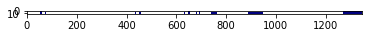

In [3]:
thres_list = [-66,-75,-84]
range_val = [3]#, 6, 7, 8, 9]
rssi_range = [40]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('anam')

In [4]:
model.create_refwifi(thres_list[0])
model.define_range(range_val[0], rssi_range[0])

In [5]:
model.save_refwifi()
model.save_rssiwifi()

In [6]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
#     for rang in range_val:
    for range_for_rssi in rssi_range:
        model.define_range(range_val[0], range_for_rssi)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
현재 진행 상황 : 400 회
성공 횟수 : 400회
test 횟수 : 428, 성공 횟수 : 428
100.0
0.9199083860932866
현재 진행 상황 : 100 회
성공 횟수 : 37회
현재 진행 상황 : 200 회
성공 횟수 : 40회
현재 진행 상황 : 300 회
성공 횟수 : 80회
현재 진행 상황 : 400 회
성공 횟수 : 80회
test 횟수 : 428, 성공 횟수 : 84
19.626168224299064
0.17476204093304468
현재 진행 상황 : 100 회
성공 횟수 : 48회
현재 진행 상황 : 200 회
성공 횟수 : 57회
현재 진행 상황 : 300 회
성공 횟수 : 99회
현재 진행 상황 : 400 회
성공 횟수 : 99회
test 횟수 : 428, 성공 횟수 : 99
23.130841121495326
0.2975641458912835


In [47]:
thres_list = [-66]
range_val = [4]#, 6, 7, 8, 9]
rssi_range = [32, 35, 38 ,41]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('SK미래관1층')

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../../data/SK미래관1층/train_1F/'

In [19]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
#     for rang in range_val:
    for range_for_rssi in rssi_range:
        model.define_range(range_val[0], range_for_rssi)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.18064028217048972
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.19309919882668578
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.2010964556464233
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회


In [20]:
thres_list = [-72]
range_val = [9]#, 6, 7, 8, 9]
rssi_range = [43, 45, 47 ,49]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('SK미래관1층')

In [21]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
#     for rang in range_val:
    for range_for_rssi in rssi_range:
        model.define_range(range_val[0], range_for_rssi)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.21879125177604214
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.2231086605570962
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.22989822151072162
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회


In [22]:
thres_list = [-72]
range_val = [9]#, 6, 7, 8, 9]
rssi_range = [51, 53, 55, 57, 59, 61]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('SK미래관1층')

In [23]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
#     for rang in range_val:
    for range_for_rssi in rssi_range:
        model.define_range(range_val[0], range_for_rssi)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.24251729660687804
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.24777233724806136
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회
현재 진행 상황 : 700 회
성공 횟수 : 695회
test 횟수 : 704, 성공 횟수 : 699
99.28977272727273
0.2519409758303711
현재 진행 상황 : 100 회
성공 횟수 : 98회
현재 진행 상황 : 200 회
성공 횟수 : 195회
현재 진행 상황 : 300 회
성공 횟수 : 295회
현재 진행 상황 : 400 회
성공 횟수 : 395회
현재 진행 상황 : 500 회
성공 횟수 : 495회
현재 진행 상황 : 600 회
성공 횟수 : 595회


6 258 396 546
36.0 372.0


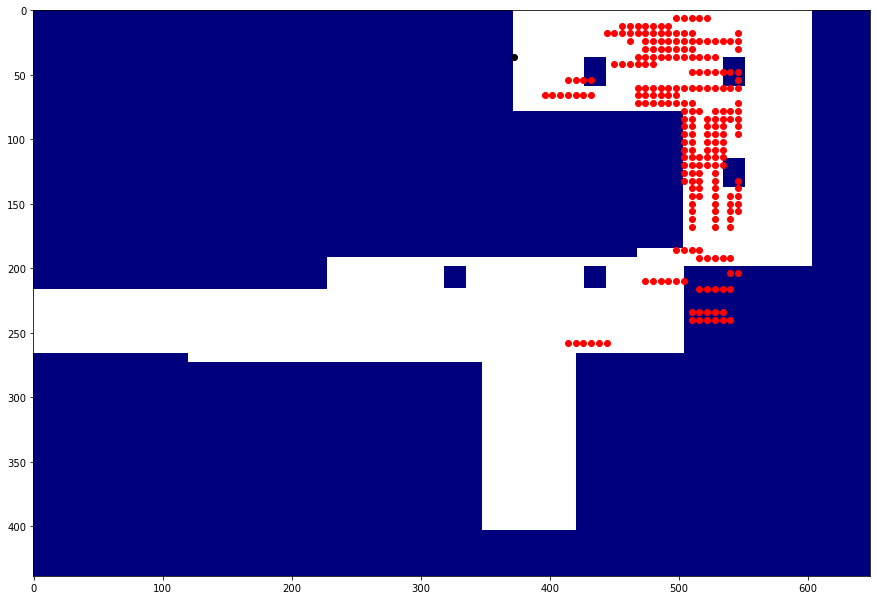

6 258 396 546
42.0 372.0


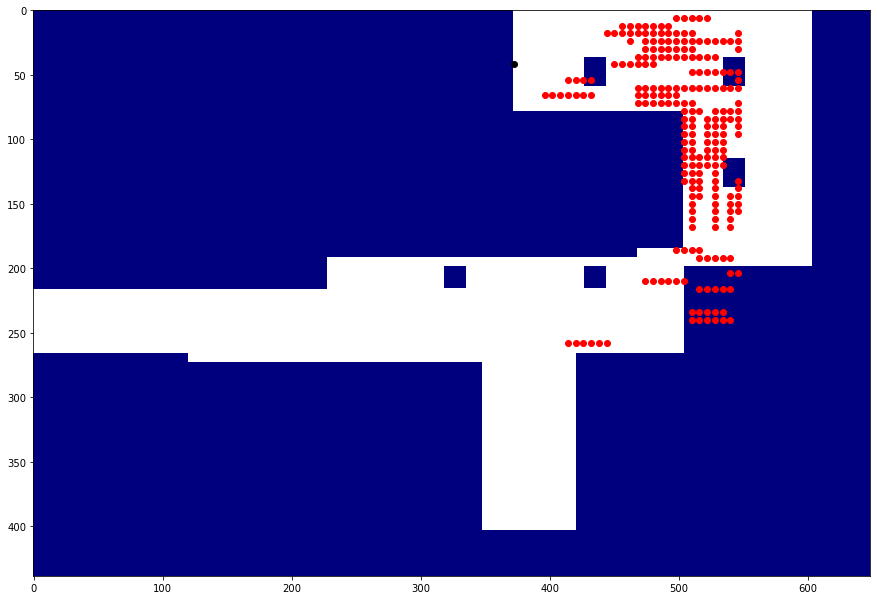

6 258 396 546
48.0 372.0


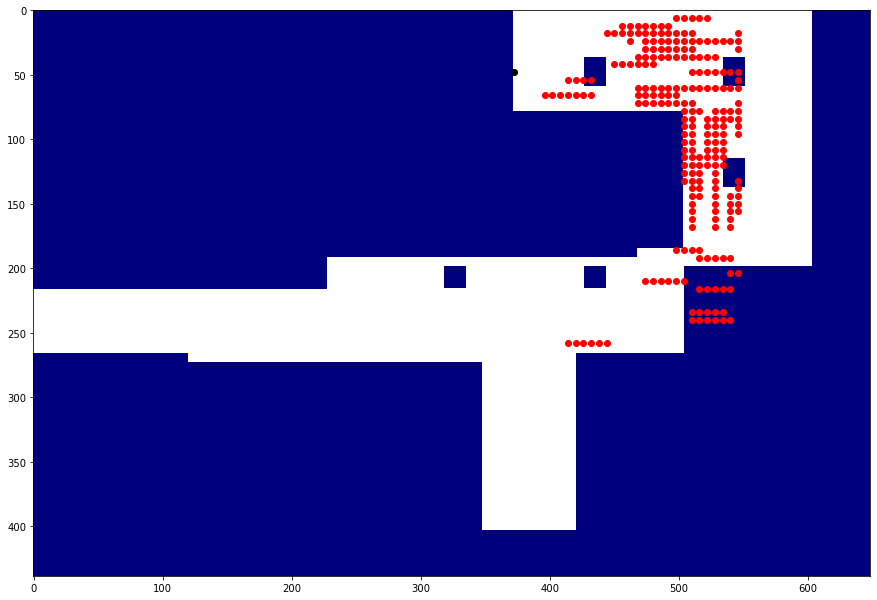

6 258 396 546
54.0 372.0


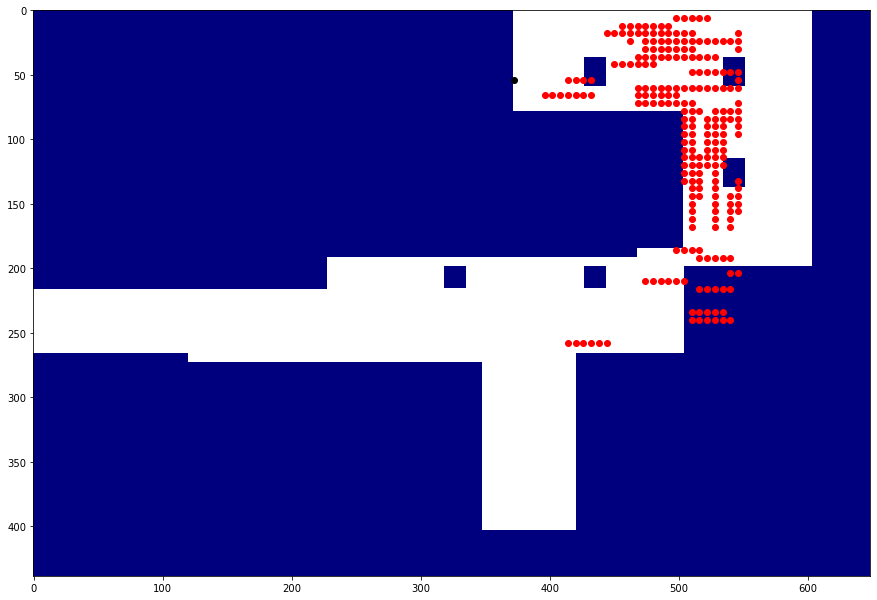

6 258 396 546
60.0 372.0


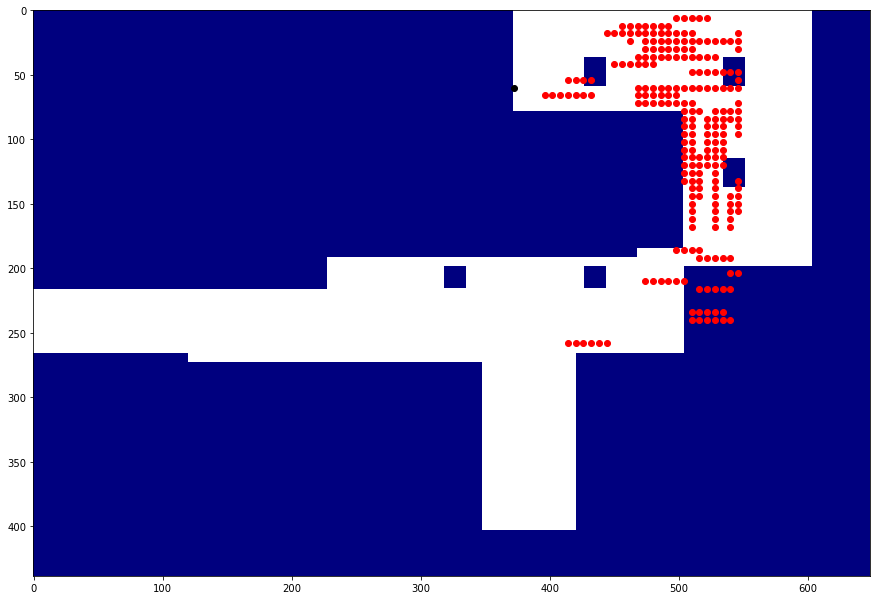

In [24]:
for i in range(len(fail)):
    x_list = fail[i][2][0]
    y_list = fail[i][2][1]
    
    ans_x = fail[i][0]
    ans_y = fail[i][1]
    
    print(min(x_list), max(x_list), min(y_list), max(y_list))

    print(ans_x, ans_y)

    # plt.figure(figsize = (15, 11))
    # plt.imshow(mag_df, cmap='jet', interpolation='none')
    # plt.scatter(org_y_list, org_x_list, c = 'b')
    # plt.scatter(y, x, c = 'r')


    plt.figure(figsize = (15, 11))
    plt.imshow(model.mag_df, cmap='jet', interpolation='none')
    plt.scatter(y_list, x_list, c = 'r')
    plt.scatter(ans_y, ans_x, c = 'black')

    plt.show()